# pandas с визуализацией

In [34]:
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: /home/kostanew/anaconda3/envs/p4env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
import matplotlib.pylab as plt # Для визуализации
import numpy as np # Для работы с массивами
import pandas as pd # Для работы с таблицами
import seaborn as sns # Для визуализации

from rdkit import Chem
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.gridspec import GridSpec

In [36]:
# Загрузка 100 строк
summary = pd.read_csv("summary.csv", index_col=0, nrows=100)

In [37]:
# Посмотрим на число строк, столбцов и наличие пропусков в дата-фрейме
print(f'Number of lines in summary: {summary.shape[0]:_}')
print(f'Number of columns in summary: {summary.shape[1]:_}')
print('---' * 20)
print('Missing values in summary:')
for col in summary.columns:
    missing_count = summary[col].isnull().sum()
    print(f'{col}: {missing_count:_}')
print('---' * 20, '\n\n')


Number of lines in summary: 100
Number of columns in summary: 22
------------------------------------------------------------
Missing values in summary:
MOSES id: 0
CONFORMER id: 0
archive name: 0
DFT TOTAL ENERGY: 0
DFT XC ENERGY: 0
DFT NUCLEAR REPULSION ENERGY: 0
DFT ONE-ELECTRON ENERGY: 0
DFT TWO-ELECTRON ENERGY: 0
DFT DIPOLE X: 0
DFT DIPOLE Y: 0
DFT DIPOLE Z: 0
DFT TOTAL DIPOLE: 0
DFT ROT CONSTANT A: 0
DFT ROT CONSTANT B: 0
DFT ROT CONSTANT C: 0
DFT HOMO: 0
DFT LUMO: 0
DFT HOMO-LUMO GAP: 0
DFT ATOMIC ENERGY: 0
DFT FORMATION ENERGY: 0
SMILES: 0
SPLITS: 0
------------------------------------------------------------ 




In [38]:
# Посмотрим основные статистики для числовых полей дата-фрейма (исключай ID)

# Исключаем столбцы содержащие "id" в названии
cols_without_id = [col for col in summary.columns if 'id' not in col.lower()]
summary[cols_without_id].describe().style.background_gradient(cmap='RdYlGn')


,DFT TOTAL ENERGY,DFT XC ENERGY,DFT NUCLEAR REPULSION ENERGY,DFT ONE-ELECTRON ENERGY,DFT TWO-ELECTRON ENERGY,DFT DIPOLE X,DFT DIPOLE Y,DFT DIPOLE Z,DFT TOTAL DIPOLE,DFT ROT CONSTANT A,DFT ROT CONSTANT B,DFT ROT CONSTANT C,DFT HOMO,DFT LUMO,DFT HOMO-LUMO GAP,DFT ATOMIC ENERGY,DFT FORMATION ENERGY
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-1184.286236,-102.412232,1844.221601,-5280.009145,2353.946408,-1.099352,-0.278916,0.086038,3.832990,0.016179,0.005686,0.004569,-0.304541,0.016191,0.320733,-1177.310394,-6.975842
std,226.266195,10.774012,254.953078,702.838149,310.079278,2.044750,2.735611,2.230878,1.762955,0.005053,0.001786,0.001125,0.016835,0.021259,0.027430,226.361577,0.792097
min,-1796.004762,-125.838075,1326.617125,-6579.191579,1711.420961,-8.053778,-6.257279,-7.360145,0.570622,0.008075,0.003063,0.002942,-0.338711,-0.026807,0.254889,-1789.774994,-8.642971
25%,-1336.556781,-110.451093,1620.637578,-5808.805381,2049.494203,-2.401856,-2.205548,-1.180444,2.452427,0.012180,0.004366,0.003712,-0.316369,0.000968,0.302628,-1330.288837,-7.719727
50%,-1265.181331,-103.247003,1910.134756,-5401.430609,2415.970971,-1.238798,-0.434086,0.129862,3.714071,0.015623,0.005272,0.004435,-0.309231,0.014274,0.320845,-1258.236656,-6.861192
75%,-988.548765,-92.841052,2004.898066,-4572.498863,2582.137192,0.498961,1.473367,1.441300,4.648431,0.018648,0.006426,0.005218,-0.292596,0.028323,0.333807,-982.047556,-6.399281
max,-866.179348,-82.942738,2328.022547,-3836.407361,2880.425279,2.763807,6.156508,6.329272,10.250143,0.031526,0.010471,0.008408,-0.265317,0.072599,0.393019,-858.986271,-4.957080


In [39]:
# Пример, как можно визуализировать таблицу, чтобы её было удобно посмотреть глазами

# Выбираем первые 25 строк (например)
summary_first_25 = summary.iloc[:25]

# Выбираем только столбцы с типом float64
float64_columns = summary_first_25.select_dtypes(include=['float64']).columns

# Применяем background_gradient только к float64 столбцам для лучшей визуализации
summary_first_25[float64_columns].style.background_gradient(cmap='RdYlGn')

,DFT TOTAL ENERGY,DFT XC ENERGY,DFT NUCLEAR REPULSION ENERGY,DFT ONE-ELECTRON ENERGY,DFT TWO-ELECTRON ENERGY,DFT DIPOLE X,DFT DIPOLE Y,DFT DIPOLE Z,DFT TOTAL DIPOLE,DFT ROT CONSTANT A,DFT ROT CONSTANT B,DFT ROT CONSTANT C,DFT HOMO,DFT LUMO,DFT HOMO-LUMO GAP,DFT ATOMIC ENERGY,DFT FORMATION ENERGY
0,-1300.896067,-102.375307,1658.713422,-5071.516025,2214.311790,-1.806337,-3.755724,1.719132,4.508185,0.018157,0.004653,0.004180,-0.311180,0.017776,0.328956,-1294.500711,-6.395356
1,-1300.899902,-102.429213,1680.799786,-5115.351584,2236.111433,-0.686522,-3.981607,-1.768432,4.410426,0.015678,0.005575,0.004542,-0.302982,0.018677,0.321659,-1294.500711,-6.399191
2,-1300.904099,-102.418626,1659.441723,-5073.046880,2215.149221,-2.391864,-2.333644,0.157712,3.345411,0.017954,0.004708,0.004167,-0.311098,0.018097,0.329195,-1294.500711,-6.403388
3,-1300.897094,-102.430203,1679.790185,-5113.238802,2235.012044,0.788940,-3.194971,-3.144447,4.551683,0.015418,0.005608,0.004613,-0.302444,0.019934,0.322378,-1294.500711,-6.396383
4,-1300.900022,-102.406318,1675.256567,-5104.235443,2230.515201,1.317857,-3.884962,-2.107323,4.611994,0.015423,0.005608,0.004526,-0.300709,0.010465,0.311174,-1294.500711,-6.399311
5,-1300.894981,-102.449810,1685.260907,-5124.555389,2240.880631,-3.211841,0.104902,-0.662510,3.281135,0.018241,0.005084,0.004491,-0.307153,0.019568,0.326721,-1294.500711,-6.394270
6,-1364.634545,-110.469814,1991.334523,-5821.897826,2576.441291,-1.665626,-3.932513,0.509835,4.301034,0.016222,0.003744,0.003309,-0.312438,0.007731,0.320169,-1356.890047,-7.744498
7,-1364.635238,-110.464226,2012.273527,-5863.649856,2597.249613,0.323793,-4.626937,-0.030043,4.638350,0.019395,0.003671,0.003449,-0.316316,0.005738,0.322054,-1356.890047,-7.745191
8,-1364.633060,-110.450988,2000.626198,-5840.274947,2585.510211,-4.255090,-0.810502,1.792435,4.687807,0.011805,0.004588,0.003528,-0.298148,0.015040,0.313187,-1356.890047,-7.743013
9,-1364.614756,-110.464684,1980.033227,-5798.658132,2564.518143,0.341087,-2.764843,-0.625985,2.855268,0.014852,0.003794,0.003299,-0.311766,-0.000842,0.310925,-1356.890047,-7.724709


# Исследование распределения признаков в данных

In [40]:
# Загрузка всех строк и выбор только по одной молекуле
#df_full = pd.read_csv("summary.csv", index_col=0, nrows=1000)
df_full = pd.read_csv("summary.csv", index_col=0)


df_full = df_full[df_full['CONFORMER id'] == 0]
df_full["Br_count"] = df_full["SMILES"].str.count("Br")


In [41]:
df_full = df_full[df_full['CONFORMER id'] == 0] # Выбираем только по одной конформации каждой молекулы
df_full = df_full[df_full["DFT TOTAL ENERGY"] < 0.] # Убираем из набора данных "плохо" посчитанные молекулы

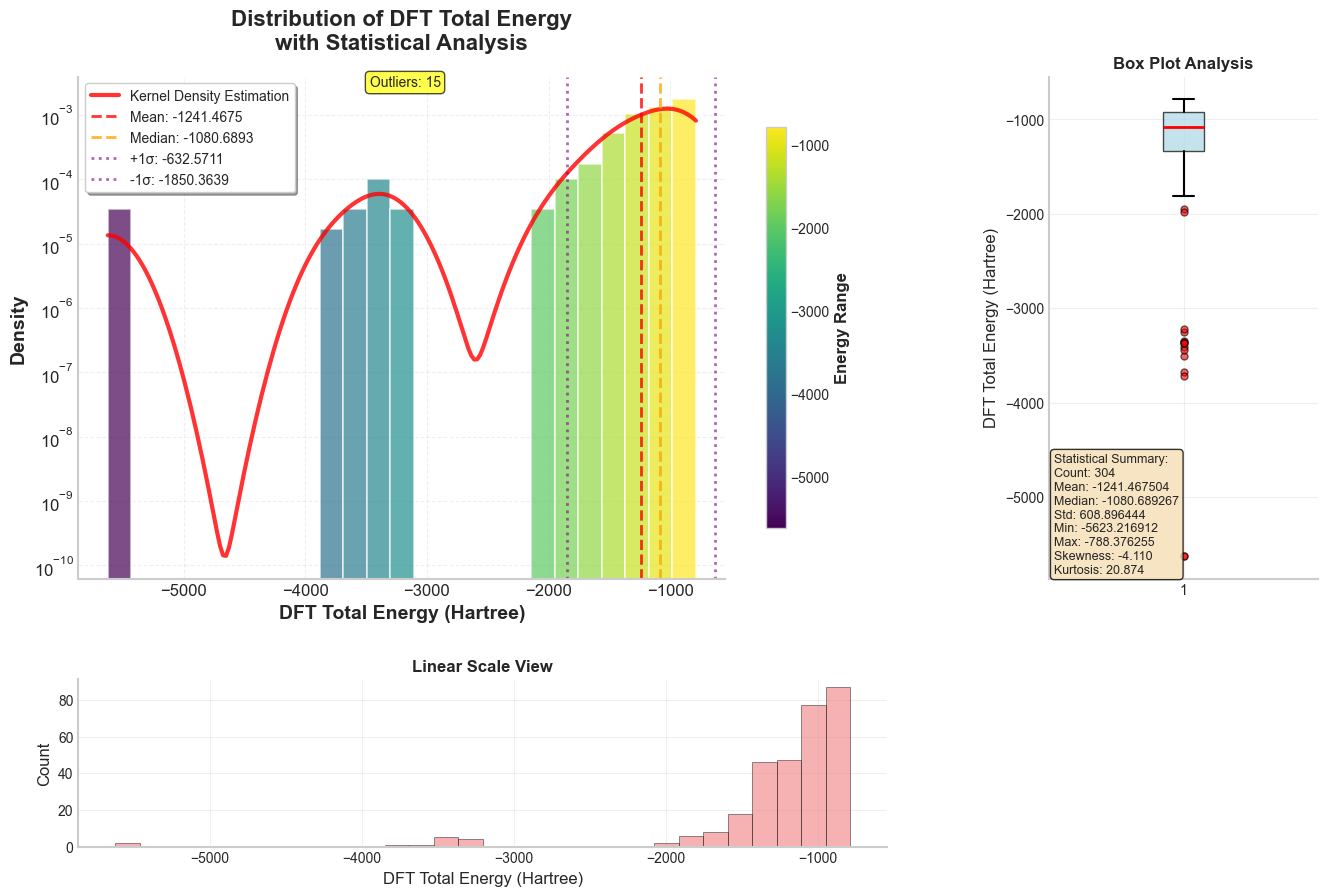

In [42]:
# Ниже приведён пример, как можно сделать достаточно красивый график
# Но он так же ещё достаточно простой, с помощью Matplotlib вы можете 
# управлять настройками графика очень низкоуровнево и добиться качества
# превосходящего BI-графики. 
# А ещё вы можете добавлять кастомные шрифты, цвета, водяные знаки, логотипы и т.д.
# Единсвенный момент, что для такого красивого графика придётся потратить 
# немного больше времени на код (число строк может достигать несколько сотен - это нормально:)
# Здесь же всё же пример больше для дальнейшего вдохновения

# Устанавливаем стиль
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Создаем фигуру с настройками
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[3, 1], 
              hspace=0.3, wspace=0.3)

# Основной график
ax_main = fig.add_subplot(gs[0, 0])
ax_hist = fig.add_subplot(gs[1, 0])
ax_box = fig.add_subplot(gs[0, 1])

# Данные
data = df_full["DFT TOTAL ENERGY"].values
data_clean = data[~np.isnan(data)]

# Основной гистограммный график
n, bins, patches = ax_main.hist(data_clean, bins=25, alpha=0.8, 
                                color='steelblue', edgecolor='white', 
                                linewidth=1.2, density=True)

# Градиентная заливка для столбцов
colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Добавляем кривую плотности
from scipy import stats
kde = stats.gaussian_kde(data_clean)
x_range = np.linspace(data_clean.min(), data_clean.max(), 200)
density = kde(x_range)
ax_main.plot(x_range, density, 'r-', linewidth=3, alpha=0.8, 
             label='Kernel Density Estimation')

# Настройка осей
ax_main.set_xlabel('DFT Total Energy (Hartree)', fontsize=14, fontweight='bold')
ax_main.set_ylabel('Density', fontsize=14, fontweight='bold')
ax_main.set_title('Distribution of DFT Total Energy\nwith Statistical Analysis', 
                  fontsize=16, fontweight='bold', pad=20)

# Логарифмическая шкала для y
ax_main.set_yscale('log')

# Сетка
ax_main.grid(True, alpha=0.3, linestyle='--')
ax_main.set_axisbelow(True)

# Статистические линии
mean_val = np.mean(data_clean)
median_val = np.median(data_clean)
std_val = np.std(data_clean)

ax_main.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                alpha=0.8, label=f'Mean: {mean_val:.4f}')
ax_main.axvline(median_val, color='orange', linestyle='--', linewidth=2, 
                alpha=0.8, label=f'Median: {median_val:.4f}')
ax_main.axvline(mean_val + std_val, color='purple', linestyle=':', linewidth=2, 
                alpha=0.6, label=f'+1σ: {mean_val + std_val:.4f}')
ax_main.axvline(mean_val - std_val, color='purple', linestyle=':', linewidth=2, 
                alpha=0.6, label=f'-1σ: {mean_val - std_val:.4f}')

# Легенда
ax_main.legend(loc='upper left', frameon=True, fancybox=True, 
               shadow=True, fontsize=10)

# Форматирование осей
ax_main.tick_params(axis='both', which='major', labelsize=12)
ax_main.tick_params(axis='both', which='minor', labelsize=10)

# Дополнительная гистограмма (обычная шкала)
ax_hist.hist(data_clean, bins=30, alpha=0.6, color='lightcoral', 
             edgecolor='black', linewidth=0.5)
ax_hist.set_xlabel('DFT Total Energy (Hartree)', fontsize=12)
ax_hist.set_ylabel('Count', fontsize=12)
ax_hist.set_title('Linear Scale View', fontsize=12, fontweight='bold')
ax_hist.grid(True, alpha=0.3)

# Box plot
box_plot = ax_box.boxplot(data_clean, patch_artist=True, 
                          boxprops=dict(facecolor='lightblue', alpha=0.7),
                          medianprops=dict(color='red', linewidth=2),
                          whiskerprops=dict(color='black', linewidth=1.5),
                          capprops=dict(color='black', linewidth=1.5),
                          flierprops=dict(marker='o', markerfacecolor='red', 
                                        markersize=5, alpha=0.6))
ax_box.set_title('Box Plot Analysis', fontsize=12, fontweight='bold')
ax_box.set_ylabel('DFT Total Energy (Hartree)', fontsize=12)
ax_box.grid(True, alpha=0.3)

# Статистический текст
stats_text = f"""Statistical Summary:
Count: {len(data_clean):,}
Mean: {mean_val:.6f}
Median: {median_val:.6f}
Std: {std_val:.6f}
Min: {np.min(data_clean):.6f}
Max: {np.max(data_clean):.6f}
Skewness: {stats.skew(data_clean):.3f}
Kurtosis: {stats.kurtosis(data_clean):.3f}"""

ax_box.text(0.02, 0.25, stats_text, transform=ax_box.transAxes, 
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Настройка границ и отступов
for ax in [ax_main, ax_hist, ax_box]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

# Цветовая панель для основного графика
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=bins.min(), vmax=bins.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_main, shrink=0.8, aspect=20)
cbar.set_label('Energy Range', fontsize=12, fontweight='bold')

# Добавляем аннотации для выбросов
Q1 = np.percentile(data_clean, 25)
Q3 = np.percentile(data_clean, 75)
IQR = Q3 - Q1
outliers = data_clean[(data_clean < Q1 - 1.5*IQR) | (data_clean > Q3 + 1.5*IQR)]

if len(outliers) > 0:
    ax_main.annotate(f'Outliers: {len(outliers)}', 
                     xy=(0.45, 0.98), xycoords='axes fraction',
                     fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Сохранение с высоким качеством
plt.savefig('dft_energy_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Отображаем график под ячейкой
plt.show()
